*The above references an opinion and is for information purposes only. It is not intended to be investment advice. Seek a duly licensed professional for investment advice.*


# Investment Model

Say you're an investor with an initial wealth $\mathcal W_0$. There is a risky asset of returns $\mu_k = m + \sigma\epsilon_k$ with $\epsilon_k$ a gaussian white noise.

As an investor we want to know what ratio of our cash $\phi_k$ should go into the risky asset at every time step $k$.

Our wealth's dynamics is defined recursively with the wealth increaments being equal to the gains from the risky investments over the period. We suppose that riskless rates are zero and therefore, the wealth at time $k + 1$ is
$$
\mathcal W_{k + 1} = \mathcal W_{k + 1}\left( 1 + \mu_k\phi_k \right).
$$

At a time horizon $K$, we thus have
$$
\mathcal W_{K} = \mathcal W_{0}\prod_{k = 0}^{K - 1}\left( 1 + \mu_k\phi_k \right).
$$

Now, say we have an ideal investment goal of value $\omega = \left( 1 + R \right)\mathcal W_{0}$. Following  [Bouchaud and Potters](https://www.cambridge.org/core/books/theory-of-financial-risk-and-derivative-pricing/5BBBA04CE72ED9E5E7C1C028D9A94FCB "My Quant bible") (see page 218), I choose to minimise

$$
\left< \left( \mathcal{W}_K^2 - \omega \right)^2 \right>.
$$
After some algebra, the above quantity can be expressed as
$$
\mathcal{W}_0^2 \prod_{k = 0}^{K - 1} B\left( \phi_k \right) - 2\omega\mathcal{W}_0\prod_{k = 0}^{K - 1} A\left( \phi_k \right) + \omega^2
$$
with $A\left(\varphi\right) = 1 + m\varphi$ and $B\left(\varphi\right) = \left[ A\left(\varphi\right)^2 + \sigma^2\varphi^2 \right]$.

From these formulae, it appears that the terms in the products are invariant to the allocation orders. This means that if we were to intervert $\phi_k$ with $\phi_{k'}$, the value of the objective function would still be the same. This invites us to consider only one allocation value $\phi$ through out the investment period and minimize the function
$$
\left< \left( \mathcal{W}_K^2 - \omega \right)^2 \right> = \mathcal{W}_0^2 B\left( \phi \right)^K - 2\omega\mathcal{W}_0 A\left( \phi \right)^K + \omega^2
$$

The model is strictly equivalent to playing $K$ times a game of independant returns $\mu = m + \sigma\epsilon$ with a bet $\phi$.

### Important Note
The assumption on the noise process $\epsilon_k$ is very simplistic as returns should rather be described with a student distribution - or any other fat tail capturing statistical distribution. As we are interested in a methodology to compute investment weights accross time for a goal based investment, we will not concern ourselves with these advanced statistical aspects.

# Code
First we import the necessary packages and functions. Note that we will make use of python's ```numba``` library to speed up the simulations of wealth.

In [1]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

from numba import njit              # Useful to speed up loops on numpy objects

AWESOME_PURPLE = 0.55, 0.42, 1

And now the parameters...

In [2]:
m = 0.02592           # Average monthly returns of the ETF CAC40 Lyxor from 2010 to 2020 (included)
sigma = 0.06164       # Standard deviation of that same asset, same period

K = 12*30             # Investment period - rather long to mimic retirement planning, i.e. 30 years
S = 1000000           # Number of Mone-Carlo samples for final computations
W0 = 1                # Initial wealth -- as the equations are linear in W_0, we can set its value to 1

R = 10                # Expected returns...
omega = (1 + R)*W0    # written as an investment goal

## First helper functions for the optimization
Let's first define $A$ and $B$ as introduced in the first section and the resulting objective function. Note that the ```@njt``` decorator is added at the top of the functions as it seems to speed up calculations a little.
```python
@njit(nogil = True)
def A(phi):
    return 1 + m*phi

@njit(nogil = True)
def B(phi):
    return A(phi)**2 + sigma**2*phi**2

@njit(nogil = True)
def Objective(phi):
    objective = W0**2*np.power(B(phi), K)
    objective -= 2*omega*W0*np.power(A(phi), K)
    objective += omega**2
    return objective

%timeit optimize.minimize(Objective, 0, bounds = [[0, 1]], method = "SLSQP")
1.01 ms ± 4.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

# @njit(nogil = True)
def A(phi):
    return 1 + m*phi

# @njit(nogil = True)
def B(phi):
    return A(phi)**2 + sigma**2*phi**2

# @njit(nogil = True)
def Objective(phi):
    objective = W0**2*np.power(B(phi), K)
    objective -= 2*omega*W0*np.power(A(phi), K)
    objective += omega**2
    return objective

%timeit optimize.minimize(Objective, 0, bounds = [[0, 1]], method = "SLSQP")
1.43 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
```

In [3]:
@njit(nogil = True)
def A(phi):
    return 1 + m*phi

@njit(nogil = True)
def B(phi):
    return A(phi)**2 + sigma**2*phi**2

@njit(nogil = True)
def Objective(phi):
    objective = W0**2*np.power(B(phi), K)
    objective -= 2*omega*W0*np.power(A(phi), K)
    objective += omega**2
    return objective

## Optimization

In [4]:
results = optimize.minimize(Objective, 0, bounds = [[0, 1]], method = "SLSQP")
phi_optim = results.x.copy()[0]
print(f"Optimal allocation: {phi_optim:.4f}")

Optimal allocation: 0.2453


## Result analysis
Now that we have the results of the optimization, we know the amount to place at each period. We now implement, the methods for the Monte-Carlo Simulations for the analysis of the optimal strategy $\phi^*$.
- ```computeRiskyReturns(...)``` simulates risky returns
- ```computeWealth(...)``` simulates our wealth, and
- ```computeTargetProba(...)``` computes from the Monte-Carlo Samples, the probability of reaching the investment goal and beyond.

In [5]:
@njit(nogil = True)
def computeRiskyReturns(K, S):
    np.random.seed(0)
    mu = np.zeros(shape = (S, K))
    for s in range(S):
        for k in range(K):
            mu[s, k] = np.random.normal(loc = m, scale = sigma)
    return mu

@njit(nogil = True)
def computeWealth(phi, W0, mu):
    S, K = mu.shape
    W = np.zeros(shape = S)
    for s in range(S):
        WK = W0
        for k in range(K):
            risky_returns = mu[s, k]*phi
            WK *= np.maximum(0, 1 + risky_returns[0])
        W[s] = WK
    return W

@njit(nogil = True)
def computeTargetProba(phi, W0, mu, R):
    return (computeWealth(phi, W0, mu) > omega).mean()

mu = computeRiskyReturns(K, S)
goal_proba = computeTargetProba(np.array([phi_optim]), W0, mu, R)
print(f"Proba to achieve goal: {goal_proba:.4f}")

Proba to achieve goal: 0.2919


It seems that reaching the goal is not necessarily the most probable outcome as the distribution skews positively with $K$. The longer the maturity of the investment, the higher are extrem positive.

Nonetheless, we should have a look at the minimum expected returns we ought to get with that investment strategy. To do so, we compute the cumulative distribution and search for the overall investment's return values which are very likely to occur.

In [6]:
WK = computeWealth(np.array(K*[phi_optim]), W0, mu)
proba, bins, _ = plt.hist(WK, bins = 1000, density = True, cumulative = True)
plt.close()
R_values = (.5*(bins[1:] + bins[:-1]) - 1)/W0

Two KPI's are of interest here. First the minimal return the investor should expect with probability 95% $R_{95}$. Second, the average of the 5% worst values, the 5% expected shortfall $ES_{5}$.

In [7]:
R_95 = (bins[np.searchsorted(proba, .05) - 1] - 1)/W0
ES_5 = ((WK*(WK < (1 + R_95)*W0)).sum()/(WK < (1 + R_95)*W0).sum() - 1)/W0

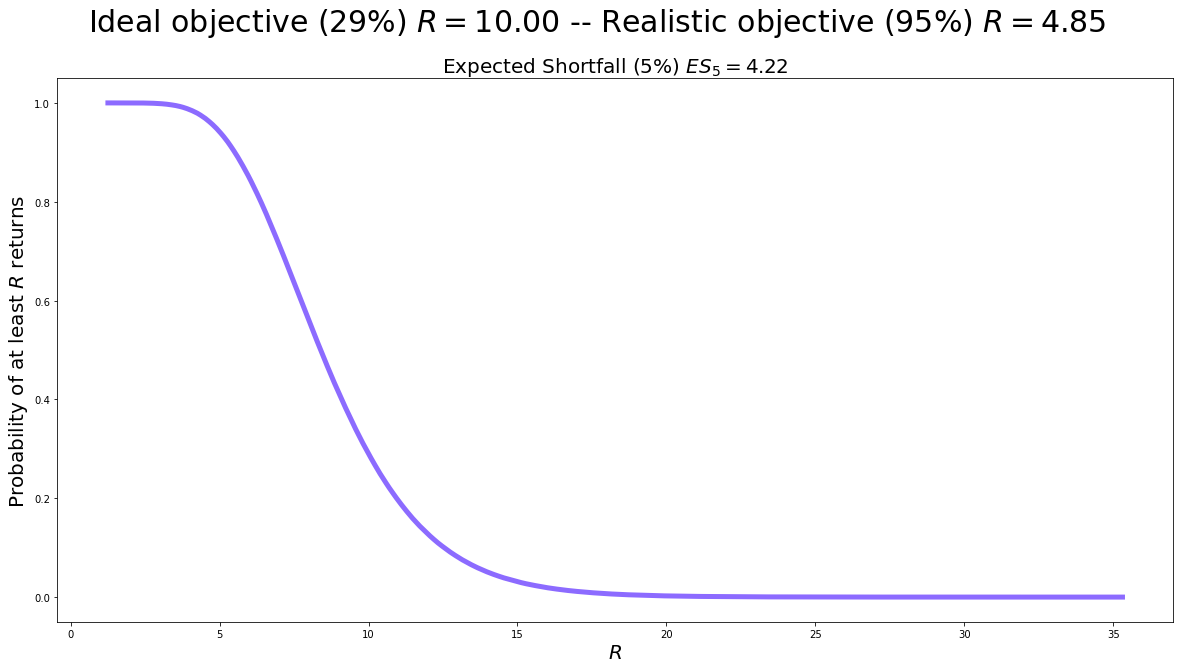

In [8]:
_ = plt.figure(figsize = (20, 10))
_ = plt.plot(R_values, 1 - proba, color = AWESOME_PURPLE, linewidth = 5)
_ = plt.xlabel(r"$R$", fontsize = 20)
_ = plt.ylabel(r"Probability of at least $R$ returns", fontsize = 20)
_ = plt.suptitle(f"Ideal objective ({100*goal_proba:.0f}%) " + r"$R = " + f"{R:.2f}" + r"$ -- Realistic objective (95%) $R = " + f"{R_95:.2f}" + r"$", fontsize = 30)
_ = plt.title(f"Expected Shortfall (5%) " + r"$ES_5 = " + f"{ES_5:.2f}" + "$", fontsize = 20)

# Conclusion

This short study has extremly positive outcomes. Mainly because it supposes that the risky asset's returns are gaussian white noise.

Nonetheless, the methodology holds. For more accurate statistical models, a complete switch to Monte Carlo Methods would be required. A better model would
- use a stochastic volatility model for the returns, allowing for sudden jumps in the price of the risky asset,
- input regular payments to the fund.

Another improvement would be to use a dynamical optimal strategy of Bouchaud et al's, going backward in time. I did not use this methodology as I was really curious of the optimal strategy with a static approach. 

And of course, the strategy could also be backtested which would provide even greater insights.